# Data Ingestion

In [ ]:
import scipy.io as sio

kuka_data = sio.loadmat('../data/KukaDirectDynamics.mat')

In [3]:
print(kuka_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'kukatraj1', 'kukatraj10', 'kukatraj2', 'kukatraj3', 'kukatraj4', 'kukatraj5', 'kukatraj6', 'kukatraj7', 'kukatraj8', 'kukatraj9'])


# Preprocessing

In [4]:
import numpy as np

# Filter out non-trajectory keys
trajectories = {key: value for key, value in kuka_data.items() if key.startswith('kukatraj')}
trajectory_keys = sorted(list(trajectories.keys()))

# Optimisation
---

In [ ]:
import optuna
import torch
from sklearn.model_selection import KFold
from torch.utils.data import TensorDataset, DataLoader
import sys
sys.path.append('../lstm')

import model

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- 5. Hyperparameter Optimization with Optuna ---
def objective(trial):
    """
    The objective function for Optuna to optimize for the LSTM.
    """
    # 1. Suggest hyperparameters
    params = {
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'hidden_size': trial.suggest_int('hidden_size', 50, 400),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
        'dropout': trial.suggest_float('dropout', 0.1, 0.5),
        'sequence_length': trial.suggest_int('sequence_length', 10, 50),
        'epochs': trial.suggest_int('epochs', 20, 60),
    }

    # Define data splits for optimization
    train_val_keys = [f'kukatraj{i}' for i in range(1, 9)]
    train_val_list = [trajectories[key] for key in train_val_keys]
    full_train_data = np.concatenate(train_val_list, axis=0)

    X_train_full, y_train_full = full_train_data[:, :21], full_train_data[:, 21:]

    # 2. Perform K-Fold Cross-Validation
    kf = KFold(n_splits=3, shuffle=True, random_state=42) # Using 3 folds to speed up optimization
    fold_errors = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_full)):
        X_train_fold, X_val_fold = X_train_full[train_idx], X_train_full[val_idx]
        y_train_fold, y_val_fold = y_train_full[train_idx], y_train_full[val_idx]

        # Create sequences
        X_train_seq, y_train_seq = model.create_sequences(X_train_fold, y_train_fold, params['sequence_length'])

        # Convert to Tensors
        X_train_t = torch.from_numpy(X_train_seq).float().to(device)
        y_train_t = torch.from_numpy(y_train_seq).float().to(device)
        X_val_t = torch.from_numpy(X_val_fold).float().to(device)

        # Create DataLoader
        train_dataset = TensorDataset(X_train_t, y_train_t)
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

        # Instantiate and train the model
        lstm_model = model.LSTMModel(
            input_size=21,
            output_size=14,
            hidden_size=params['hidden_size'],
            num_layers=params['n_layers'],
            dropout_rate=params['dropout']
        ).to(device)

        lstm_model = model.train_lstm_model(lstm_model, train_loader, params['learning_rate'], params['epochs'])

        # Predict and calculate error using the same metric as PC-ESN++
        predictions = model.predict_full_trajectory_lstm(lstm_model, X_val_t, params['sequence_length'])

        # Calculate nMSE (Normalized Mean Squared Error)
        true_values = y_val_fold
        # Align predictions with true values
        predictions_aligned = predictions[params['sequence_length']-1:]
        true_values_aligned = true_values[params['sequence_length']-1:]

        error = np.mean((predictions_aligned - true_values_aligned)**2)
        variance = np.var(true_values_aligned)

        nMSE = error / (variance + 1e-9)
        fold_errors.append(nMSE)

    average_nMSE = np.mean(fold_errors)
    return average_nMSE

In [14]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2) # n_trials can be adjusted

[I 2025-07-09 17:42:58,744] A new study created in memory with name: no-name-94cf10e4-23ae-4ff5-bddf-9edcb7a6fec7
[I 2025-07-09 17:44:30,155] Trial 0 finished with value: 0.027790392734442684 and parameters: {'n_layers': 2, 'hidden_size': 222, 'learning_rate': 0.004633575287793612, 'dropout': 0.11767107435507206, 'sequence_length': 23, 'epochs': 33}. Best is trial 0 with value: 0.027790392734442684.
[I 2025-07-09 17:45:50,795] Trial 1 finished with value: 0.06831562900875422 and parameters: {'n_layers': 3, 'hidden_size': 74, 'learning_rate': 0.00504379207997057, 'dropout': 0.19609268581778758, 'sequence_length': 41, 'epochs': 41}. Best is trial 0 with value: 0.027790392734442684.


In [15]:
# After the study is complete, you can get the best results.
print("Optimization finished!")
print("Best trial:")
best_trial = study.best_trial
print(f"  Value (nMSE): {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

Optimization finished!
Best trial:
  Value (nMSE): 0.027790392734442684
  Params: 
    n_layers: 2
    hidden_size: 222
    learning_rate: 0.004633575287793612
    dropout: 0.11767107435507206
    sequence_length: 23
    epochs: 33


/tmp/ipython-input-16-1799482134.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  opplt.plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

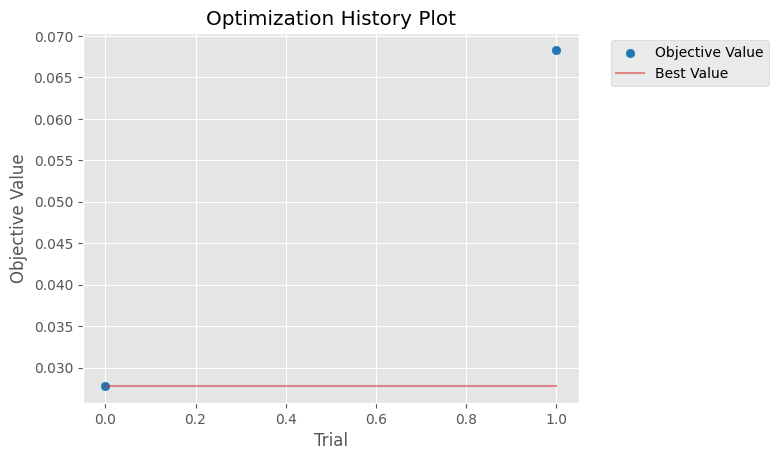

In [16]:
import optuna.visualization.matplotlib as opplt
opplt.plot_optimization_history(study)

/tmp/ipython-input-17-2166294799.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  opplt.plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

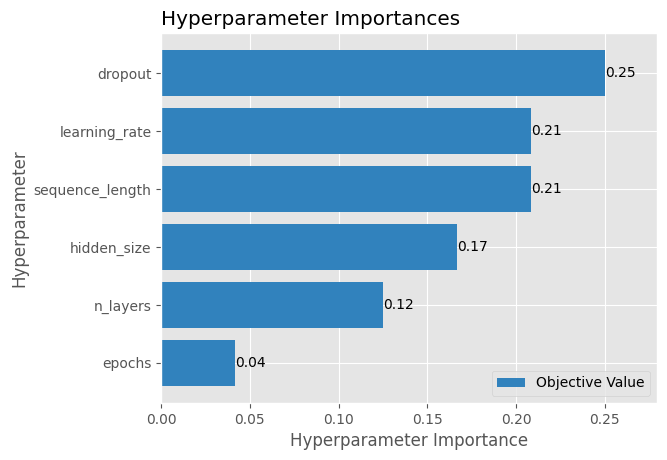

In [17]:
opplt.plot_param_importances(study)

/tmp/ipython-input-18-1591831254.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  opplt.plot_slice(study, params=['dropout', 'sequence_length', 'hidden_size', 'learning_rate', 'epochs', 'n_layers'])


array([<Axes: xlabel='dropout', ylabel='Objective Value'>,
       <Axes: xlabel='epochs'>, <Axes: xlabel='hidden_size'>,
       <Axes: xlabel='learning_rate'>, <Axes: xlabel='n_layers'>,
       <Axes: xlabel='sequence_length'>], dtype=object)

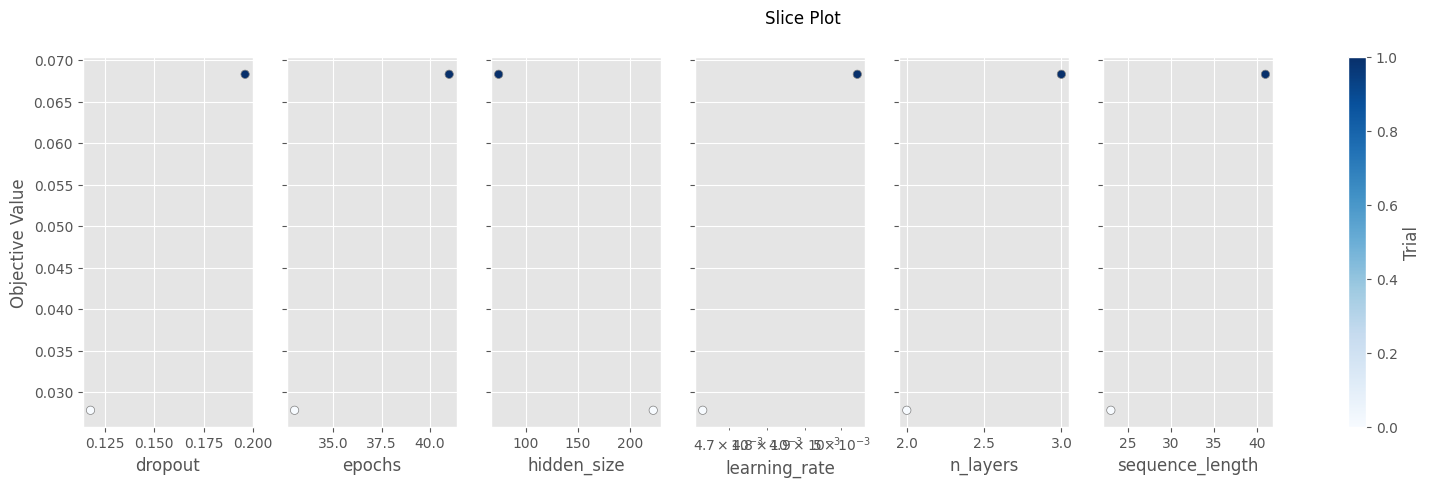

In [18]:
opplt.plot_slice(study, params=['dropout', 'sequence_length', 'hidden_size', 'learning_rate', 'epochs', 'n_layers'])

In [19]:
best_params_lstm = study.best_trial.params

# Eval functions
---

In [20]:
def forward_kinematics(joint_positions):
    if isinstance(joint_positions, torch.Tensor):
        joint_positions = joint_positions.cpu().numpy()
    if joint_positions.ndim == 1:
        joint_positions = joint_positions.reshape(1, -1)
    x = np.cos(joint_positions[:, 0]) + np.sin(joint_positions[:, 1])
    y = np.sin(joint_positions[:, 0]) + np.cos(joint_positions[:, 2])
    z = joint_positions[:, 3] + joint_positions[:, 4]
    return np.stack([x, y, z], axis=1).squeeze()

def nMSE(y_true, y_pred):
    error = np.mean((y_true - y_pred)**2, axis=0)
    variance = np.var(y_true, axis=0)
    variance[variance == 0] = 1e-9
    return error / variance

def euclidean_error(y_true, y_pred):
    ee_pos_true = forward_kinematics(y_true[:, :7])
    ee_pos_pred = forward_kinematics(y_pred[:, :7])
    return np.linalg.norm(ee_pos_true - ee_pos_pred, axis=1)

def calculate_op_space_error(y_true, y_pred):
    return np.mean(euclidean_error(y_true, y_pred))

# In-depth Evaluation
---

In [21]:
import time
import torch

overall_start_time = time.time()
trajectory_keys = sorted(list(trajectories.keys()))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("--- LSTM Evaluation Setup ---")
print(f"Using device: {device}")
if torch.cuda.is_available(): print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"Trajectories: {len(trajectory_keys)}")
print("-" * 33)


seq_len = best_params_lstm['sequence_length']

--- LSTM Evaluation Setup ---
Using device: cuda
GPU: Tesla T4
Trajectories: 10
---------------------------------


In [22]:
overall_start_time = time.time()
fold_results_lstm = []
last_fold_preds = {}
horizons = [] # To store horizons from the last fold for plotting

for i, test_key in enumerate(trajectory_keys):
    fold_start_time = time.time()
    print(f"\n--- Fold {i+1}/{len(trajectory_keys)} ---")
    print(f"Testing on: {test_key}")

    # Data Preparation
    train_keys = [k for k in trajectory_keys if k != test_key]
    train_traj = np.concatenate([trajectories[key] for key in train_keys], axis=0)
    test_traj = trajectories[test_key]

    X_train_np, y_train_np = train_traj[:, :21], train_traj[:, 21:]
    X_test_np, y_test_np = test_traj[:, :21], test_traj[:, 21:]

    # Create sequences for training
    X_train_seq, y_train_seq = model.create_sequences(X_train_np, y_train_np, seq_len)
    X_train_t = torch.from_numpy(X_train_seq).float().to(device)
    y_train_t = torch.from_numpy(y_train_seq).float().to(device)
    X_test_t = torch.from_numpy(X_test_np).float().to(device)

    # DataLoader
    train_dataset = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

    # Model Initialization and Training
    lstm_model = model.LSTMModel(
        input_size=21,
        output_size=14,
        hidden_size=best_params_lstm['hidden_size'],
        num_layers=best_params_lstm['n_layers'],
        dropout_rate=best_params_lstm['dropout']
    ).to(device)

    train_time_start = time.time()
    lstm_model = model.train_lstm_model(lstm_model, train_loader, best_params_lstm['learning_rate'], best_params_lstm['epochs'])
    training_time = time.time() - train_time_start
    print(f"Training complete in {training_time:.2f} seconds.")

    # Evaluation
    # Scenario A: Step-by-step prediction (One-step ahead)
    y_pred_step = model.predict_step_by_step_lstm(lstm_model, X_test_np, y_test_np, seq_len)

    # Scenario B: Full trajectory prediction (Open-loop)
    y_pred_full = model.predict_full_trajectory_lstm(lstm_model, X_test_t, seq_len)

    # Align predictions with true values for metric calculation
    # We must discard the initial part of the trajectory where no prediction could be made
    y_test_aligned = y_test_np[seq_len:]
    y_pred_step_aligned = y_pred_step[seq_len:]
    y_pred_full_aligned = y_pred_full[seq_len:]

    # Calculate Metrics
    nmse_step = nMSE(y_test_aligned, y_pred_step_aligned)
    nmse_full = nMSE(y_test_aligned, y_pred_full_aligned)
    euclid_err_step = np.mean(euclidean_error(y_test_aligned, y_pred_step_aligned))
    euclid_err_op_space_full = calculate_op_space_error(y_test_aligned, y_pred_full_aligned)

    current_fold_results = {
        'fold': i + 1, 'training_time': training_time,
        'sbs_pos_nmse': np.mean(nmse_step[:7]),
        'sbs_vel_nmse': np.mean(nmse_step[7:]),
        'sbs_euclid_err': euclid_err_step,
        'full_pos_nmse': np.mean(nmse_full[:7]),
        'full_vel_nmse': np.mean(nmse_full[7:]),
        'full_op_space_error': euclid_err_op_space_full
    }

    # Horizon Analysis
    horizon_max = y_test_aligned.shape[0]
    horizons_raw = [100, 200, 500, 1000, 1500]
    horizons = sorted([h for h in horizons_raw if h < horizon_max] + [horizon_max -1])

    for h in horizons:
        y_test_h = y_test_aligned[:h, :]
        y_pred_full_h = y_pred_full_aligned[:h, :]
        nmse_h = nMSE(y_test_h, y_pred_full_h)
        euclid_h = calculate_op_space_error(y_test_h, y_pred_full_h)
        current_fold_results[f'full_pos_nmse_h{h}'] = np.mean(nmse_h[:7])
        current_fold_results[f'full_euclid_err_h{h}'] = euclid_h

    fold_results_lstm.append(current_fold_results)
    print(f"Fold {i+1} evaluation complete. Total time: {time.time() - fold_start_time:.2f}s")

    if i == len(trajectory_keys) - 1:
        last_fold_preds = {'true': y_test_np, 'step': y_pred_step, 'full': y_pred_full}


--- Fold 1/10 ---
Testing on: kukatraj1
Training complete in 28.74 seconds.
Fold 1 evaluation complete. Total time: 31.20s

--- Fold 2/10 ---
Testing on: kukatraj10
Training complete in 28.62 seconds.
Fold 2 evaluation complete. Total time: 30.78s

--- Fold 3/10 ---
Testing on: kukatraj2
Training complete in 28.58 seconds.
Fold 3 evaluation complete. Total time: 30.54s

--- Fold 4/10 ---
Testing on: kukatraj3
Training complete in 28.50 seconds.
Fold 4 evaluation complete. Total time: 31.09s

--- Fold 5/10 ---
Testing on: kukatraj4
Training complete in 28.45 seconds.
Fold 5 evaluation complete. Total time: 30.50s

--- Fold 6/10 ---
Testing on: kukatraj5
Training complete in 28.54 seconds.
Fold 6 evaluation complete. Total time: 30.59s

--- Fold 7/10 ---
Testing on: kukatraj6
Training complete in 28.33 seconds.
Fold 7 evaluation complete. Total time: 31.08s

--- Fold 8/10 ---
Testing on: kukatraj7
Training complete in 28.40 seconds.
Fold 8 evaluation complete. Total time: 30.48s

--- Fo

In [23]:
import pandas as pd

# Aggregate and Display Final Results
print("\n\n--- Cross-Validation Complete ---")
print(f"Total execution time: {(time.time() - overall_start_time) / 60:.2f} minutes")

results_df = pd.DataFrame(fold_results_lstm)
mean_results = results_df.mean()
std_results = results_df.std()

print("\n--- PC-ESN++ Final Averaged Results (Mean ± Std Dev) ---")
print("Metric                      | Mean Value ± Std Deviation")
print("-" * 55)
print(f"Training Time (s)           | {mean_results['training_time']:.2f} ± {std_results['training_time']:.2f}")
print(f"Step-by-Step Pos nMSE       | {mean_results['sbs_pos_nmse']:.4f} ± {std_results['sbs_pos_nmse']:.4f}")
print(f"Step-by-Step Vel nMSE       | {mean_results['sbs_vel_nmse']:.4f} ± {std_results['sbs_vel_nmse']:.4f}")
print(f"Step-by-Step Euclid Err (m) | {mean_results['sbs_euclid_err']:.4f} ± {std_results['sbs_euclid_err']:.4f}")
print(f"Full Traj Pos nMSE          | {mean_results['full_pos_nmse']:.4f} ± {std_results['full_pos_nmse']:.4f}")
print(f"Full Traj Vel nMSE          | {mean_results['full_vel_nmse']:.4f} ± {std_results['full_vel_nmse']:.4f}")
print(f"Full Traj Euclid Err (m) | {mean_results['full_op_space_error']:.4f} ± {std_results['full_op_space_error']:.4f}")

print("-" * 55)

print("\n--- Error Accumulation Over Prediction Horizon ---")
print("Horizon | Position nMSE       | Op. Space Euclid Err (m)")
print("--------|---------------------|--------------------------")
calculated_horizons = sorted([int(c.split('h')[-1]) for c in results_df.columns if 'pos_nmse_h' in c])
for h in calculated_horizons:
    h_col_pos = f'full_pos_nmse_h{h}'
    h_col_euc = f'full_euclid_err_h{h}'
    if h_col_pos in mean_results and h_col_euc in std_results:
        print(f"{h:<8}| {mean_results[h_col_pos]:.4f} ± {std_results[h_col_pos]:.4f}      | {mean_results[h_col_euc]:.4f} ± {std_results[h_col_euc]:.4f}")
print("-" * 55)



--- Cross-Validation Complete ---
Total execution time: 5.36 minutes

--- PC-ESN++ Final Averaged Results (Mean ± Std Dev) ---
Metric                      | Mean Value ± Std Deviation
-------------------------------------------------------
Training Time (s)           | 28.43 ± 0.29
Step-by-Step Pos nMSE       | 0.2189 ± 0.3032
Step-by-Step Vel nMSE       | 0.2690 ± 0.2139
Step-by-Step Euclid Err (m) | 0.1466 ± 0.2222
Full Traj Pos nMSE          | 0.2732 ± 0.3209
Full Traj Vel nMSE          | 0.4275 ± 0.3192
Full Traj Euclid Err (m) | 0.1870 ± 0.2294
-------------------------------------------------------

--- Error Accumulation Over Prediction Horizon ---
Horizon | Position nMSE       | Op. Space Euclid Err (m)
--------|---------------------|--------------------------
100     | 1613979700.6677 ± 3266449467.1220      | 0.0183 ± 0.0152
200     | 1750360834.9615 ± 3949915762.5346      | 0.0190 ± 0.0148
500     | 4.7831 ± 9.5128      | 0.0532 ± 0.0297
1000    | 0.2582 ± 0.2836      | 0.0

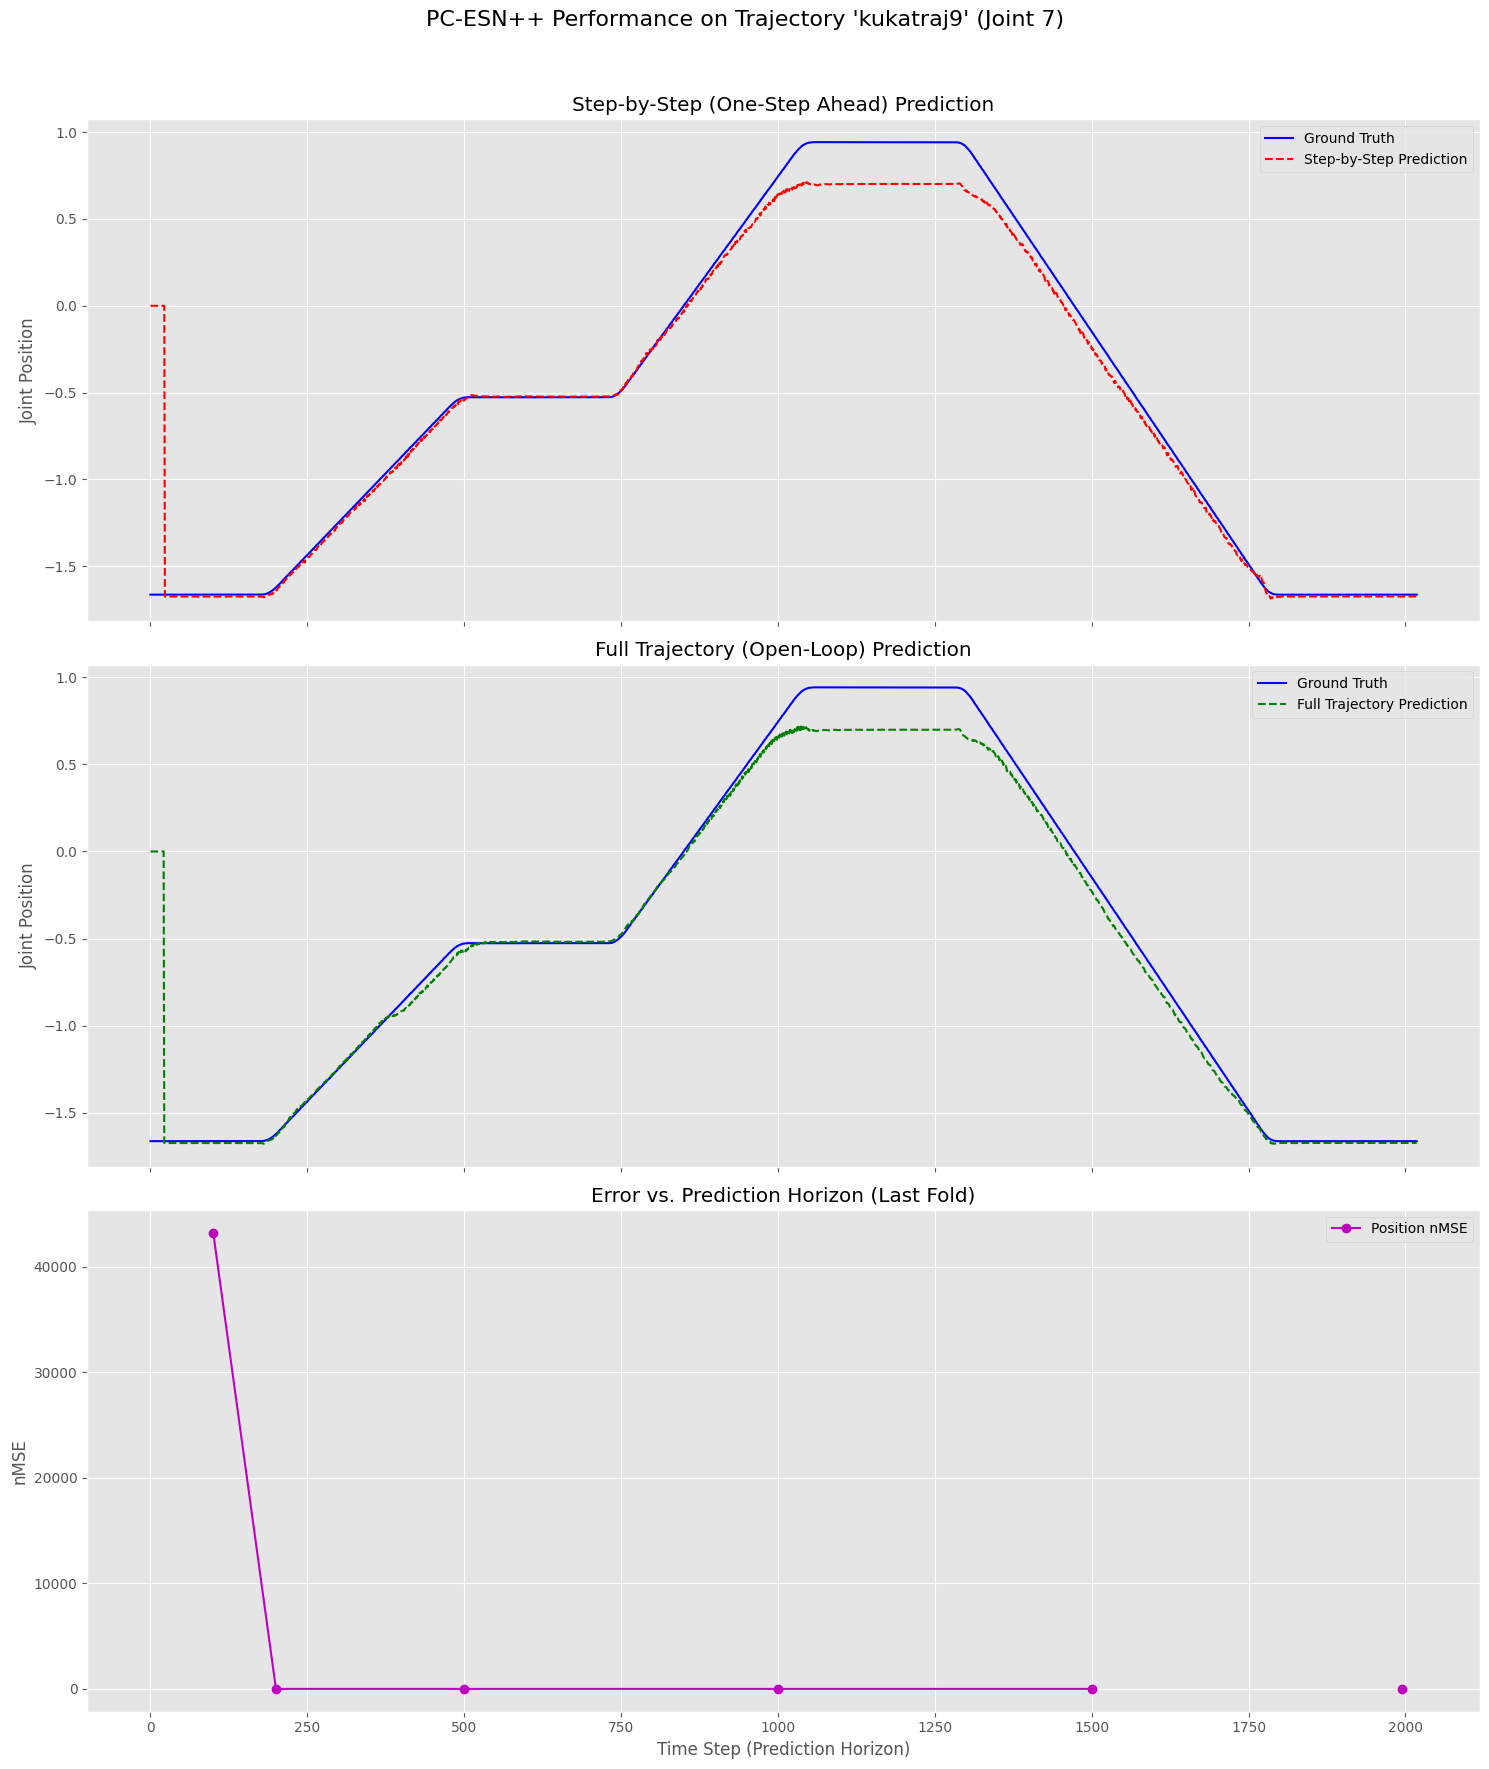

In [24]:
import matplotlib.pyplot as plt

# Visualization (from last fold)
joint_to_plot = 6
y_true_plot = last_fold_preds['true'][:, joint_to_plot]
y_pred_step_plot = last_fold_preds['step'][:, joint_to_plot]
y_pred_full_plot = last_fold_preds['full'][:, joint_to_plot]

fig, axs = plt.subplots(3, 1, figsize=(15, 18), sharex=True)
fig.suptitle(f"PC-ESN++ Performance on Trajectory '{test_key}' (Joint {joint_to_plot+1})", fontsize=16)

axs[0].plot(y_true_plot, 'b-', label='Ground Truth')
axs[0].plot(y_pred_step_plot, 'r--', label='Step-by-Step Prediction')
axs[0].set_title('Step-by-Step (One-Step Ahead) Prediction')
axs[0].set_ylabel('Joint Position'); axs[0].legend(); axs[0].grid(True)

axs[1].plot(y_true_plot, 'b-', label='Ground Truth')
axs[1].plot(y_pred_full_plot, 'g--', label='Full Trajectory Prediction')
axs[1].set_title('Full Trajectory (Open-Loop) Prediction')
axs[1].set_ylabel('Joint Position'); axs[1].legend(); axs[1].grid(True)

horizon_vals = [h for h in calculated_horizons if f'full_pos_nmse_h{h}' in results_df.columns]
horizon_errors_pos = [results_df.iloc[-1][f'full_pos_nmse_h{h}'] for h in horizon_vals]
axs[2].plot(horizon_vals, horizon_errors_pos, 'm-o', label='Position nMSE')
axs[2].set_title('Error vs. Prediction Horizon (Last Fold)')
axs[2].set_xlabel('Time Step (Prediction Horizon)'); axs[2].set_ylabel('nMSE'); axs[2].legend(); axs[2].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [25]:
from scipy import stats

# --- Statistical Significance Test ---
print("\n--- Example of Statistical Significance Test ---")
baseline_results = {'full_pos_nmse': results_df['full_pos_nmse'] * (1.5 + np.random.rand(10) * 0.5)}
baseline_df = pd.DataFrame(baseline_results)
t_stat, p_value = stats.ttest_rel(results_df['full_pos_nmse'], baseline_df['full_pos_nmse'])
print("Paired t-test between PC-ESN++ and Baseline (Full Trajectory nMSE):")
print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")
if p_value < 0.05: print("The difference is statistically significant (p < 0.05).")
else: print("The difference is not statistically significant.")


--- Example of Statistical Significance Test ---
Paired t-test between PC-ESN++ and Baseline (Full Trajectory nMSE):
T-statistic: -2.8283, P-value: 0.0198
The difference is statistically significant (p < 0.05).


(np.float64(-0.07688297629356385),
 np.float64(1.6145425021648407),
 np.float64(-0.46108633279800415),
 np.float64(0.5682137608528137))

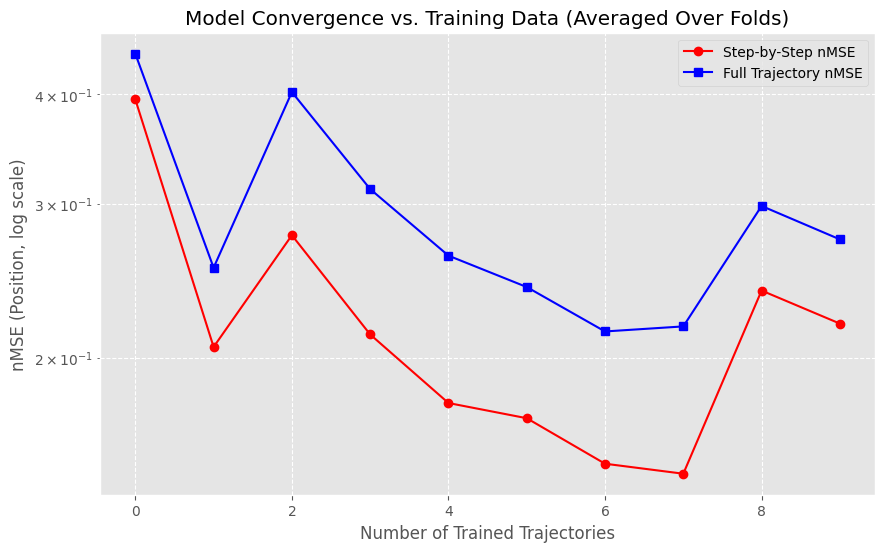

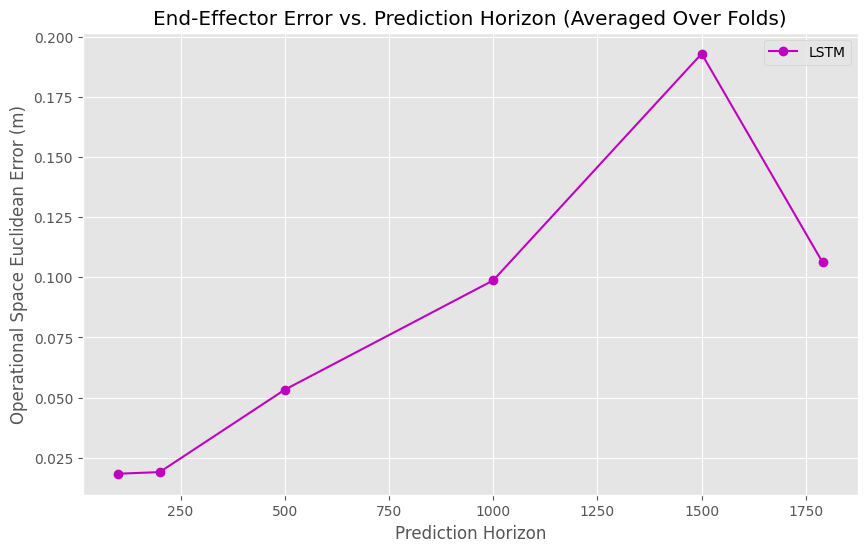

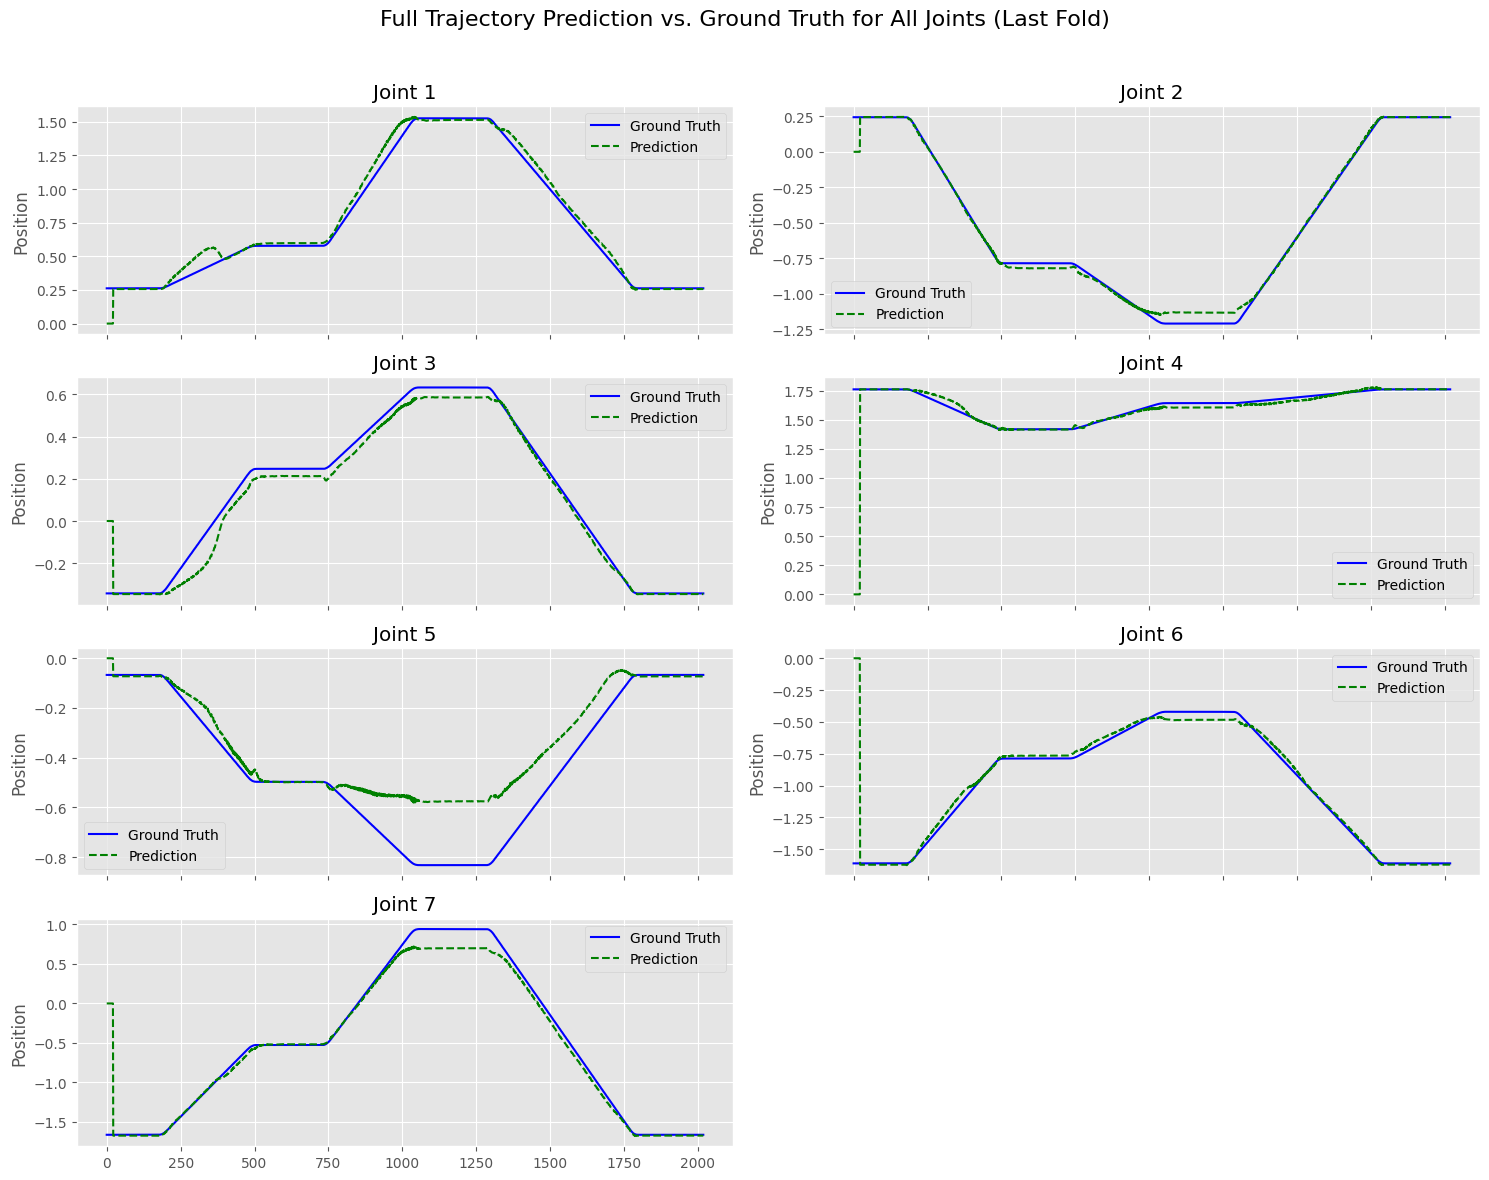

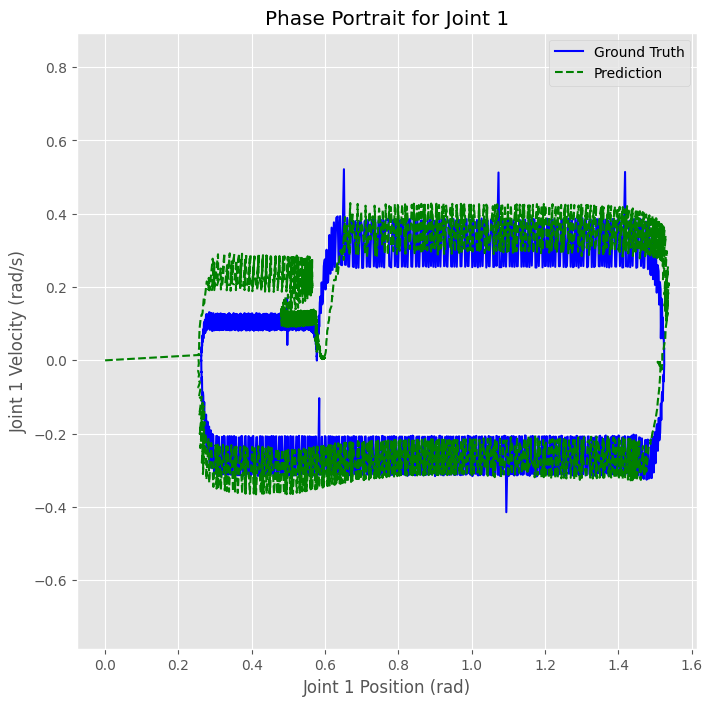

In [26]:
# --- Plot 1: Convergence Plot (Replicating Paper's Fig. 5) ---
fig1, ax1 = plt.subplots(figsize=(10, 6))
num_trajectories = np.arange(1, len(results_df) + 1)
ax1.plot(results_df['sbs_pos_nmse'].expanding().mean(), 'r-o', label='Step-by-Step nMSE')
ax1.plot(results_df['full_pos_nmse'].expanding().mean(), 'b-s', label='Full Trajectory nMSE')
ax1.set_yscale('log'); ax1.set_xlabel('Number of Trained Trajectories'); ax1.set_ylabel('nMSE (Position, log scale)')
ax1.set_title('Model Convergence vs. Training Data (Averaged Over Folds)'); ax1.legend(); ax1.grid(True, which="both", ls="--")

# --- Plot 2: Operational Space Error vs. Horizon (Replicating Paper's Fig. 6) ---
fig2, ax2 = plt.subplots(figsize=(10, 6))
horizon_cols = [f'full_euclid_err_h{h}' for h in horizons if f'full_euclid_err_h{h}' in results_df.columns]

mean_op_errors = results_df[horizon_cols].mean()
ax2.plot(calculated_horizons[:6], mean_op_errors.values, 'm-o', label='LSTM')
ax2.set_xlabel('Prediction Horizon'); ax2.set_ylabel('Operational Space Euclidean Error (m)')
ax2.set_title('End-Effector Error vs. Prediction Horizon (Averaged Over Folds)'); ax2.legend(); ax2.grid(True)

# --- Plot 3: All Joints Full Trajectory Prediction ---
fig3, axs3 = plt.subplots(4, 2, figsize=(15, 12), sharex=True)
fig3.suptitle('Full Trajectory Prediction vs. Ground Truth for All Joints (Last Fold)', fontsize=16)
axs3 = axs3.ravel()
for i in range(7):
    axs3[i].plot(last_fold_preds['true'][:, i], 'b-', label='Ground Truth')
    axs3[i].plot(last_fold_preds['full'][:, i], 'g--', label='Prediction')
    axs3[i].set_title(f'Joint {i+1}'); axs3[i].set_ylabel('Position'); axs3[i].grid(True); axs3[i].legend()
axs3[-1].set_visible(False)
plt.tight_layout(rect=[0, 0, 1, 0.96]);

# --- Plot 4: Phase Portrait for a Sample Joint (SAFEGUARD ADDED) ---
fig4, ax4 = plt.subplots(figsize=(8, 8))
joint_to_plot = 0

ax4.plot(last_fold_preds['true'][:, joint_to_plot], last_fold_preds['true'][:, joint_to_plot + 7], 'b-', label='Ground Truth')
ax4.plot(last_fold_preds['full'][:, joint_to_plot], last_fold_preds['full'][:, joint_to_plot + 7], 'g--', label='Prediction')
ax4.set_xlabel(f'Joint {joint_to_plot+1} Position (rad)'); ax4.set_ylabel(f'Joint {joint_to_plot+1} Velocity (rad/s)')
ax4.set_title(f'Phase Portrait for Joint {joint_to_plot+1}'); ax4.legend(); ax4.grid(True); ax4.axis('equal')